# Seismic event detection

## Problem statement

In this tutorial, we will analyse timeseries data recorded by an acoustic sensor in a lab friction experiment (courtesy of Evangelos Korkolis, Utrecht University). During this experiment, the sample exhibited stick-slip deformation, the laboratory-scale analogue of earthquakes. Just prior to a major stick-slip event, the sample would start to emit tiny acoustic emissions ("foreshocks"), which are detected by piezo-electric sensors ("seismometers") installed around the sample. Some of these acoustic emissions are clearly visible in the timeseries, whereas others occur near the level of the noise. Classical methods (such as ST/LT thresholding) don't perform well on the smaller acoustic emissions, and so we will use machine learning to lower the automatic detection threshold.

## Data description

The training/testing data are small, randomly selected segments of acoustic timeseries data, each segment consisting of 1024 datapoints. Associated with each segment is a binary label that is `0` when the segment only contains noise, and is `1` when the segment contains one or more acoustic emissions. The training and testing data are shuffled, so that there is no temporal relation between the segments.

In [1]:
# Import the libraries
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import gzip
import pickle


def load_data():
    with gzip.GzipFile("data.tar.gz", "r") as f:
        data = pickle.load(f)
    return data["train_data"], data["train_labels"], data["test_data"], data["test_labels"]


# Load the dataset
train_signals, train_labels, test_signals, test_labels = load_data()

# For convolutional layers, an additional dimension needs to be added
train_signals = np.expand_dims(train_signals, 2)
test_signals = np.expand_dims(test_signals, 2)

print(train_signals.shape, test_signals.shape)

(1440, 1024, 1) (360, 1024, 1)


## Data visualisation

As always, it's good to first have a look at some examples from the training data set. The code below plots "event" signals on the left, and "noise" signals on the right:

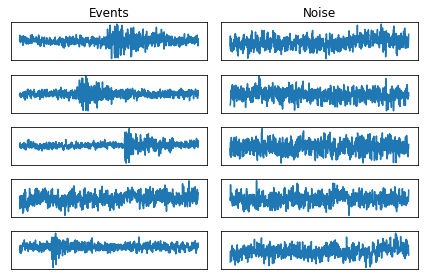

In [2]:
# Select training signals of events
events = (train_labels == 1)
event_signals = train_signals[events][:5].reshape((5, -1))

# Select training signals of noise (no events)
noise_signals = train_signals[~events][:5].reshape((5, -1))

# Plot 5 examples of events and noise
for i in range(5):
    # Events
    plt.subplot(5, 2, 1+2*i)
    if i == 0:
        plt.title("Events")
    plt.plot(event_signals[i])
    plt.xticks([])
    plt.yticks([])
    
    # Noise
    plt.subplot(5, 2, 2+2*i)
    if i == 0:
        plt.title("Noise")
    plt.plot(noise_signals[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

## Model construction

Your task will be to construct a neural network (dense, convolutional, or a combination of both) that takes a 1D timeseries of size 1024 as an input, and outputs a single scalar between 0 and 1 (0 corresponds to "no event", 1 corresponds to "yes event"). In the code below, the output layer is given, everything else is up to you.

In [3]:
# Keras default initialiser = glorot_uniform
# A better initialiser for ReLU activations = he_normal
initializer = "he_normal"

model = keras.Sequential([
    # Insert your architecture here
    # Examples of layers you could include:
    #
    # Fully-connected:  keras.layers.Dense(128, activation=tf.nn.relu, kernel_initializer=initializer)
    # Convolutional:    keras.layers.Conv1D(64, kernel_size=5, activation=tf.nn.relu, kernel_initializer=initializer, padding="same")
    # Max pooling:      keras.layers.MaxPooling1D()
    # Flattening:       keras.layers.Flatten()
    #
    
    # Output layer: 1 output, sigmoid activation
    keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer, input_shape=train_signals[0].shape),
    keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer),
    keras.layers.MaxPooling1D(),
    keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer),
    keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer),
    keras.layers.MaxPooling1D(),
    keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer),
    keras.layers.Conv1D(16, kernel_size=5, activation=tf.nn.relu, padding="same", kernel_initializer=initializer),
    keras.layers.MaxPooling1D(),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation=tf.nn.relu, kernel_initializer=initializer),
    keras.layers.Dense(1, activation=tf.nn.sigmoid, kernel_initializer="glorot_normal")
])

# Compile and print a summary
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())

W0902 08:29:47.345406 16320 deprecation.py:506] From C:\Users\marti\Anaconda3\envs\TriesteWin\lib\site-packages\tensorflow\python\ops\init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0902 08:29:47.946701 16320 deprecation.py:323] From C:\Users\marti\Anaconda3\envs\TriesteWin\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1024, 16)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1024, 16)          1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 512, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 512, 16)           1296      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 512, 16)           1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 256, 16)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 256, 16)           1

## Training

Make sure to experiment with different training durations (`epochs`) to ensure that the model was trained long enough, but not too long...

In [4]:
model.fit(
    train_signals, 
    train_labels, 
    validation_data=(test_signals, test_labels),
    verbose=1,
    epochs=10)

Train on 1440 samples, validate on 360 samples
Epoch 1/10
1440/1440 [==============================] - 5s 4ms/sample - loss: 0.6844 - acc: 0.5715 - val_loss: 0.6404 - val_acc: 0.5528
Epoch 2/10
1440/1440 [==============================] - 4s 3ms/sample - loss: 0.6292 - acc: 0.7090 - val_loss: 0.6017 - val_acc: 0.6639
Epoch 3/10
1440/1440 [==============================] - 4s 2ms/sample - loss: 0.5975 - acc: 0.7264 - val_loss: 0.5711 - val_acc: 0.7250
Epoch 4/10
1440/1440 [==============================] - 4s 3ms/sample - loss: 0.5603 - acc: 0.7458 - val_loss: 0.5345 - val_acc: 0.7750
Epoch 5/10
1440/1440 [==============================] - 4s 3ms/sample - loss: 0.5204 - acc: 0.7806 - val_loss: 0.5012 - val_acc: 0.8306
Epoch 6/10
1440/1440 [==============================] - 4s 2ms/sample - loss: 0.4813 - acc: 0.8062 - val_loss: 0.4722 - val_acc: 0.8278
Epoch 7/10
1440/1440 [==============================] - 3s 2ms/sample - loss: 0.4578 - acc: 0.8076 - val_loss: 0.4476 - val_acc: 0.8444
E

## Test accuracy and visualisation

The worst-case performance of the model would be a 50-50 guess (yes/no event), which would give a test accuracy of 50% (since events and noise are evenly represented in the test set). So our trained model should perform significantly better than 50% to be useful.

In [5]:
test_loss, test_acc = model.evaluate(test_signals, test_labels)
print("Test accuracy: %.4f" % test_acc)

360/360 [==============================] - 0s 1ms/sample - loss: 0.4958 - acc: 0.8056
Test accuracy: 0.8056


Just to see what this accuracy score looks like, we can plot a number of seismograms and colour them according to the accuracy of the prediction (green = correct, red = wrong).

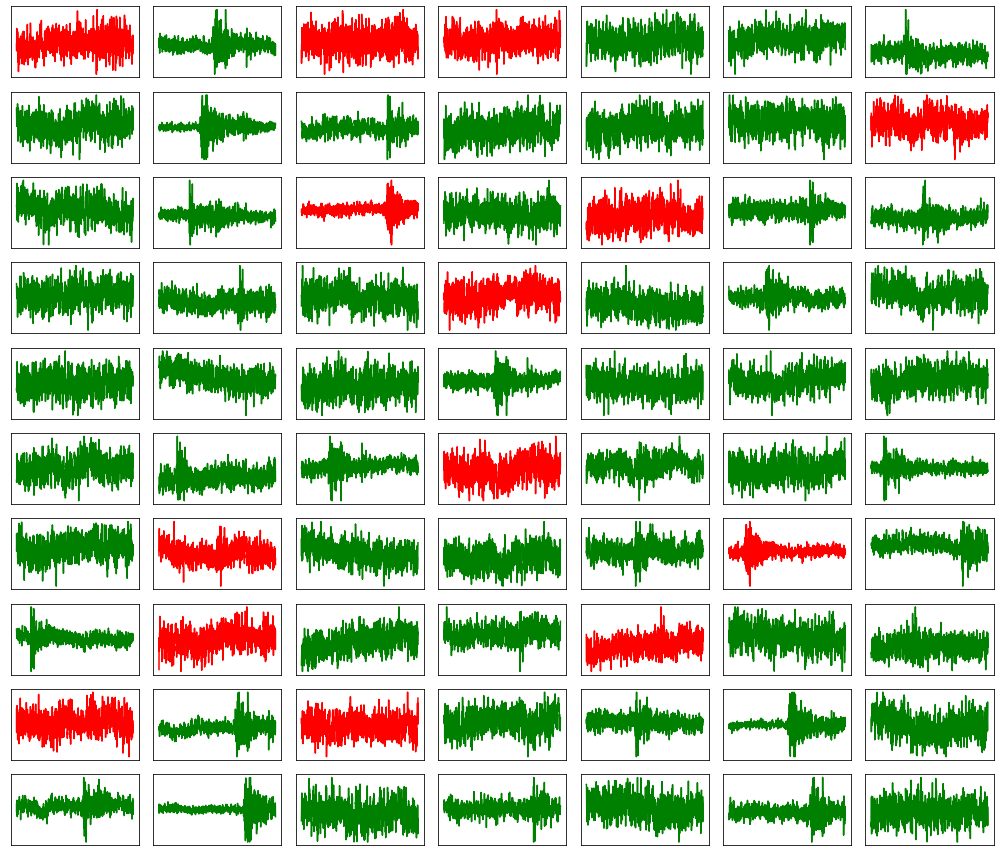

In [6]:
predictions = model.predict(test_signals)
predictions = np.round(predictions).astype(int)

fig = plt.figure(figsize=(14, 12))

# Plot 70 examples of events and noise
for i in range(10):
    for j in range(7):
        n = 7*i + j
        # Events
        plt.subplot(10, 7, 1+n)
        if predictions[n] == test_labels[n]:
            colour = "g"
        else:
            colour = "r"
        plt.plot(test_signals[n], c=colour)
        plt.xticks([])
        plt.yticks([])

plt.tight_layout()
plt.show()